In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install thop

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from tqdm import tqdm
import sys
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
import os
from thop import profile
import pandas as pd
import glob
import math
import torch.optim.lr_scheduler as lr_scheduler

# 配置运行设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 设置参数
batch_size = 32
learning_rate = 0.00003
num_epoch = 70
model_name = 'capsnet_v3'

In [3]:
device

device(type='cuda')

In [4]:
# 数据处理
normalize = transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    normalize
])

# 读取图像数据
train_dataset = ImageFolder('/kaggle/input/oral-cancer-dataset/Oral Cancer5/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageFolder('/kaggle/input/oral-cancer-dataset/Oral Cancer5/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('{0} for train. {1} for val'.format(len(train_dataset), len(test_dataset)))

1680 for train. 188 for val


In [5]:
def squash(x):
    '''
    squash函数，保证向量长度范围在(0, 1)
    :param x:
        x: (B, 10, 16)
    :return:
        squashed x (B, 10, 16)
    '''
    L = torch.norm(x, dim=2, keepdim=True)  # (B, 10, 1)
    L_square = L ** 2  # (B, 10, 1)
    c = L_square / ((1 + L_square) * L)

    s = c * x  # (B, 10, 16)
    s[s == np.nan] = 0
    return s


def dynamic_routing(x, iterations=3):
    """
    动态路由
    :param x:
        x: (B, classes, 48*7*7, out_channels_dim, 1)
    :param iterations:
    :return:
        v: next layer output (B, classes, out_channels_dim)
    """

    N = x.shape[2]  # 输入的向量个数，此处输入48个胶囊，每个胶囊提供7*7个向量
    N1 = x.shape[1]  # 输出类别个数
    B = x.shape[0]  # batch_size

    # 为每个向向量配置一个权重(初始为0)，并依据此权重累加向量(以类别为单位)，通过squash显示累加向量长度
    # 计算每个初始的每个向量与累加向量的内积，来更新该向量的权重
    b = torch.zeros(B, N1, N, 1, 1).to(x.device)  # (B, classes, 48*11*11, 1, 1)
    for _ in range(iterations):
        c = F.softmax(b, dim=1)  # (B, classes, 48*11*11, 1, 1)
        s = torch.sum(x.matmul(c), dim=2).squeeze(-1)  # (B, classes, out_channels_dim)
        v = F.softmax(s, dim=-1)  # (B, classes, out_channels_dim)
        b = b + v[:, :, None, None, :].matmul(x)
        # (B, classes, 1, 1, out_channels_dim) .* (B, classes, 32*11*11, out_channels_dim, 1)
        # = (B, classes, 32*11*11, 1, 1)
    return v

class dynamic(nn.Module):
    def __init__(self, N1, N):
        super().__init__()
        self.b = nn.Parameter(torch.randn(1, N1, N, 1, 1), requires_grad=True)
        self.N1 = N1
        self.N = N
        
    def dynamic_routing(self, x):
        """
        动态路由
        :param x:
            x: (B, classes, 48*7*7, out_channels_dim, 1)
        :param iterations:
        :return:
            v: next layer output (B, classes, out_channels_dim)
        """
        c = F.softmax(self.b, dim=1)  # (B, classes, 48*11*11, 1, 1)
        assert c.shape == self.b.shape, f"dim is change{c.shape}"
        s = torch.sum(x.matmul(c), dim=2).squeeze(-1)  # (B, classes, out_channels_dim)
        v = squash(s)  # (B, classes, out_channels_dim)
            # (B, classes, 1, 1, out_channels_dim) .* (B, classes, 32*11*11, out_channels_dim, 1)
            # = (B, classes, 32*11*11, 1, 1)
        return v
        


class PrimaryCapsuleLayer(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.primary_capsule_layer = nn.ModuleList([nn.Conv2d(512, out_dim, 3, stride=1, padding=1) for _ in range(32)])
        self.out_dim = out_dim

    def forward(self, x):
        """
        Produce primary capsules
        :param x:
            x : features with # [B, 256, 14, 14]
        :return:
            vectors (B, 64*7*7, 128)
        """
        capsules = [conv(x) for conv in self.primary_capsule_layer]  # 128 * [B, 64, 1, 1]
        capsules_reshaped = [c.reshape(-1, self.out_dim, 7 * 7) for c in capsules]
        s = torch.cat(capsules_reshaped, dim=-1).permute(0, 2, 1)  # (B, 128*1*1, 64)
        return s


class CapsLayer(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.dynamic = dynamic(2, 32 * 7 * 7)

    def forward(self, x):
        """
        predict and routing
        :param x:
            x : input vectors, # (B, 64*14*14, 8)
        :return:
            class capsules, (B, 2, 64)
        """
        x = x[:, None, ..., None]
        u_hat = torch.cat([x for _ in range(self.classes)], dim=1)
        class_capsules = self.dynamic.dynamic_routing(u_hat)
        return class_capsules


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.conv2(y)
        return self.relu(x + y)


class InceptionBlock(torch.nn.Module):
    def __init__(self, channels):
        super(InceptionBlock, self).__init__()
        self.conv_s1 = torch.nn.Conv2d(channels, channels, kernel_size=1)
        self.conv_s3 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv_s5 = torch.nn.Conv2d(channels, channels, kernel_size=5, padding=2)
        self.conv_s7 = torch.nn.Conv2d(channels, channels, kernel_size=7, padding=3)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        y = torch.cat((self.conv_s1(x), self.conv_s3(x), self.conv_s5(x), self.conv_s7(x)), dim=1)
        y = self.relu(y)
        return y

class CNNdecoder(nn.Module):
    '''
    对输入的向量进行解码使其变为原图片


    input_shape: [batch_size, vector_length]
    output_shape: [batch_size, 3, 224, 224]

    '''
    def __init__(self, out_channels_dim):
        super(CNNdecoder, self).__init__()
        self.W = nn.Parameter(torch.randn(1, 14*14, 2))  # (1, 2, 32*12*12, out_channels_dim, 8)
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv_layer1 = nn.Conv2d(out_channels_dim, 96, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(96, 48, kernel_size=3, padding=1)
        self.conv_layer3 = nn.Conv2d(48, 24, kernel_size=3, padding=1)
        self.conv_layer4 = nn.Conv2d(24, 12, kernel_size=3, padding=1)
        self.conv_layer5 = nn.Conv2d(12, 6, kernel_size=3, padding=1)
        self.conv_layer6 = nn.Conv2d(6, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        B = x.shape[0]
        v_length = x.shape[2]
#         x = x.reshape(B, 1, v_length)
        try:
            y = self.W.matmul(x)
        except:
            print('x shape:',x.shape)
            print('W shape:',self.W.shape)                    # [B, 14*14, v_length]
        y = y.permute(0, 2, 1).reshape((B, v_length, 14, 14))    # [B, v_length, 14, 14]
        y = self.relu(self.conv_layer1(self.upsample(y)))  # [B, 96, 28, 28]
        y = self.relu(self.conv_layer2(self.upsample(y)))  # [B, 48, 56, 56]
        y = self.relu(self.conv_layer3(y))   # [B, 24, 56, 56]
        y = self.relu(self.conv_layer4(self.upsample(y)))  # [B, 12, 112, 112]
        y = self.relu(self.conv_layer5(self.upsample(y)))  # [B, 6, 224, 224]
        y = self.relu(self.conv_layer6(y)) 
        return y

# 解码器
class MLPDecoder(nn.Module):
    """
    Decoder the input predicted vectors to origin images

    Usages:
        decoder = MLPDecoder([512, 1024], 16, 3, (28, 28)
        reconstructed_x = decoder(selected_capsules)
    """
    def __init__(self, hidden, in_channels, out_channels, out_shape):
        super().__init__()
        self.out_shape = out_shape
        h, w = out_shape
        self.out_channels = out_channels
        self.out_size = h * w
        self.mlp = nn.ModuleList()
        for _ in range(out_channels):
            mlp_part = nn.Sequential()
            for i, (_in, _out) in enumerate(zip([in_channels] + hidden[:-1], hidden)):
                mlp_part.add_module('Linear{0}'.format(i), nn.Linear(_in, _out))
                mlp_part.add_module('Relu{0}'.format(i), nn.ReLU())
            mlp_part.add_module('Linear{0}'.format(i+1), nn.Linear(hidden[-1], self.out_size))
            mlp_part.add_module('Sigmoid{0}'.format(i+1), nn.Sigmoid())
            self.mlp.append(mlp_part)

    def forward(self, x):
        """
        Args:
            x: (B,16)

        Return:
            reconstructed images with (B,1,28,28)
        """
        B = x.shape[0]
        output = torch.zeros((B, self.out_channels, *self.out_shape)).to(x.device)
        for i in range(self.out_channels):
            k = self.mlp[i]
            out = self.mlp[i](x)
            output[:, i, :, :] = out.reshape(B, *self.out_shape)
        return output



class CapsNet(nn.Module):
    def __init__(self, out_vector_dims):
        super().__init__()
        '''
        input_shape: [B, 3, 224, 224]

        '''
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_layer1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.conv_layer2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv_layer4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_layer5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_layer6 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.inception = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        self.conv_layer_res = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        
        self.relu = nn.ReLU(inplace=True)
        self.primary_layer = PrimaryCapsuleLayer(out_dim=out_vector_dims)
        self.caps_layer = CapsLayer(classes=2)

    def forward(self, x):
        """
        args:
            x: Input img, (B, 3, 224, 224)
        return:
            the calss capsules, ench capsule is a 16 dimension vector

        """
        x = self.relu(self.conv_layer1(x))  # [B, 16, 224, 224]
        x = self.maxpool(x)# [B, 16, 112, 112]
        x = self.relu(self.conv_layer2(x))
        y = self.maxpool(x)# [B, 32, 56, 56]
        
        
        x = self.relu(self.conv_layer3(y))
        x = self.maxpool(x) # [B, 64, 28, 28]
        x = self.conv_layer4(x) # [B, 128, 28, 28]
        
        y = self.inception(y) # [B, 128, 56, 56]
        y = self.maxpool(self.conv_layer_res(y)) # [B, 128, 28, 28]
        
        x = self.relu(x + y)
        x = self.maxpool(x) # [B, 128, 14, 14]
        x = self.relu(self.conv_layer5(x)) # [B, 256, 14, 14]
        x = self.maxpool(x)
        x = self.relu(self.conv_layer6(x)) # [B, 512, 7, 7]
        x = self.primary_layer(x)  # [B, 6*6*48, 8]
        x = self.caps_layer(x)  # (2, 48*6*6, 48, 1)
        return x


def margin_loss(y_hat, y, wrong_weight=0.5):
    '''
    args:
        y : ground truth labels (B)
        y_hat : class capsules with (B, 10, 16)

    return:
        the margin loss
    '''
    _lambda = 0.5
    m_plus = 0.9
    m_minus = 0.1
    nclass = 2

    y_norm = y_hat.norm(dim=-1)
    y = y.type(torch.int64)
    
    # 计算权重，误分类权重调高
    _, y_hat_label = torch.max(y_norm, 1)
    wrong_predict_weight = (y_hat_label != y) * wrong_weight
    wrong_predict_weight += torch.ones_like(wrong_predict_weight)
    
    
    
    T = F.one_hot(y, nclass)
    T = T.float()
    right = torch.max(torch.zeros_like(y_norm), (m_plus - y_norm) * T)
    right = right ** 2
    wrong = torch.max(torch.zeros_like(y_norm), (y_norm - m_minus) * (1 - T))
    wrong = _lambda * wrong ** 2
#     loss = torch.sum((right + wrong))
    
    loss = torch.sum((right + wrong), dim=-1)
    loss = torch.sum(loss * wrong_predict_weight)
    return loss


# 冻结网路
def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
        param.requires_grad = feature_extracting
    return 0


class CapsAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CapsNet(out_vector_dims=16)
        self.decoder = CNNdecoder(out_channels_dim=16)
#         self.classifier = Caps_classifier(18)

    def forward(self, x, y=None, reconstruct=False):
        class_capsules = self.encoder(x)
#         print(class_capsules.shape)
        if reconstruct:
            reconstructed_x = self.decoder(class_capsules)
            return class_capsules, reconstructed_x
        else:
            return class_capsules
#         B = x.shape[0]
#         if reconstruct == False:
#             return class_capsules
#         else:
#             if y != None:
#                 selected_capsules = class_capsules[torch.arange(B), y]
#             else:
#                 class_capsules_norm = class_capsules.norm(dim=-1)
#                 selected_capsules = class_capsules[torch.arange(B), torch.max(class_capsules_norm, dim=-1).indices]
#             reconstructed_x = self.decoder(selected_capsules)
#             return class_capsules, reconstructed_x

In [6]:
# 上传之前训练好的模型数据
save_path = '/kaggle/working/check_points'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
result_path = os.path.join(save_path, model_name)

# import shutil
# if os.path.exists(result_path):
#     shutil.rmtree(result_path)
# shutil.copytree(r'/kaggle/input/oral-cancer-dataset/models/check_points/capsnet_v2/', result_path)

if not os.path.exists(result_path):
    os.mkdir(result_path)

# 读取模型数据，若不存在则初始化模型
torch.autograd.set_detect_anomaly(True)
if len(glob.glob(result_path + '/**.pth')) == 0:
    net = CapsAE()
else:
    model_path = glob.glob(result_path + '/**.pth')[-1]
    net = torch.load(model_path, map_location=device)

train_test_data_path = os.path.join(result_path, 'train_test_data.csv')
if os.path.exists(train_test_data_path):
    train_test_data = pd.read_csv(train_test_data_path)
    last_epoch = train_test_data.shape[0]
    test_acc_best = train_test_data['test_acc_best'].values[-1]
else:
    train_test_data = pd.DataFrame(data=[], columns=['train_acc', 'train_loss1', 'train_loss2', 'train_eval_loss',
                                                     'train_lr',
                                                     'test_acc', 'test_loss1', 'test_loss2', 'test_eval_loss',
                                                     'epoch', 'test_acc_best'])
    last_epoch = 0
    test_acc_best = 0
assert num_epoch > last_epoch, '已达训练次数'


net = net.to(device)

# 输出模型参数与模型计算量
flops, params = profile(net, inputs=(torch.zeros((batch_size, 3, 224, 224)).to(device),), verbose=False)
print(f'number of parameter: {params}', ', %.1f GFLOPS' % (flops / 1E9 * 2))

def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters()if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
print(get_parameter_number(net.encoder))

number of parameter: 4117920.0 , 66.7 GFLOPS
{'Total': 4121056, 'Trainable': 4121056}


epoch: 44: 100%|██████████| 53/53 [03:14<00:00,  3.67s/it]
epoch[44] time[194.5]s lr:4e-05
Accuracy on train set: 97.74%, class loss: 53.99, reconstructe loss: 0
Accuracy on test set: 88.83%, class loss: 17.4, reconstructe loss: 0
epoch: 45: 100%|██████████| 53/53 [02:30<00:00,  2.83s/it]
epoch[45] time[150.0]s lr:4e-05
Accuracy on train set: 97.74%, class loss: 47.94, reconstructe loss: 0
Accuracy on test set: 90.43%, class loss: 16.37, reconstructe loss: 0
epoch: 46: 100%|██████████| 53/53 [02:28<00:00,  2.80s/it]
epoch[46] time[148.4]s lr:4e-05
Accuracy on train set: 97.68%, class loss: 49.15, reconstructe loss: 0
Accuracy on test set: 90.96%, class loss: 16.16, reconstructe loss: 0
epoch: 47: 100%|██████████| 53/53 [02:28<00:00,  2.80s/it]
epoch[47] time[148.5]s lr:4e-05
Accuracy on train set: 98.27%, class loss: 46.49, reconstructe loss: 0
Accuracy on test set: 90.96%, class loss: 14.78, reconstructe loss: 0
epoch: 48: 100%|██████████| 53/53 [02:28<00:00,  2.80s/it]
epoch[48] time

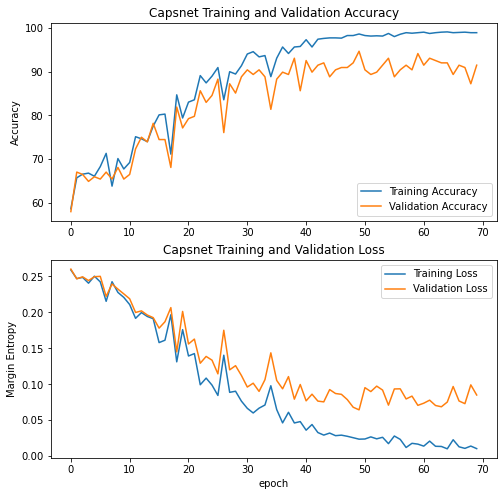

In [7]:
# optimizer = torch.optim.Adam([
#     {'params': net.encoder.parameters(), 'lr': learning_rate},
#     {'params': net.decoder.parameters(), 'lr': 0.005}
# ])
# 动态学习率
optimizer = torch.optim.Adam(net.parameters(), learning_rate)
# def lf(epoch):
#     # 前20个epoch学习率保持不变，20个epoch后学习率按比例衰减
#     if epoch <= 28:
#         return 1
#     else:
#         lr = math.exp(0.2 * (28 - epoch))
#         return lr

# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
# scheduler.last_epoch = last_epoch - 1
# scheduler.step()

def train(epoch, dataloder):
    net.train()
    t0 = time.time()
    c = 0.00007
    with tqdm(total=len(dataloder), file=sys.stdout) as pbar:
        for (X_batch, y_batch) in dataloder:
            pbar.set_description('epoch: %d' % epoch)
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            
            y_hat = net(X_batch, reconstruct=False)
    #         loss = margin_loss(y_batch, y_hat) + c * F.mse_loss(X_batch, reconstructed_x, reduction='mean')
            loss = margin_loss(y_hat, y_batch) # + c * F.mse_loss(X_batch, reconstructed_x, reduction='sum')
    #         loss = loss_f(y_hat, y_batch) + c * F.mse_loss(X_batch, reconstructed_x, reduction='mean')
            loss.backward()
            optimizer.step()
            
            pbar.update(1)
    now_lr = optimizer.param_groups[0]["lr"]
    t1 = time.time()
    print(f'epoch[{epoch}] time[{round(t1-t0,1)}]s lr:{now_lr}')
#     scheduler.step()
    return now_lr


def evaluate(data_loader, type):
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss1 = 0
        loss2 = 0
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images, reconstruct=False)
            _, predicted = torch.max(outputs.norm(dim=-1), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss1 += margin_loss(outputs,labels).item()
            #loss2 += F.mse_loss(images, reconstructed_x, reduction='sum').item()
    eval_loss = loss1 + loss2
    acc = 100 * correct / total
    print(f'Accuracy on {type} set: {round(acc, 2)}%, class loss: {round(loss1, 2)}, reconstructe loss: {round(loss2, 2)}')
    return acc, loss1 / total, loss2 / total, eval_loss / total

if __name__ == '__main__':
    weight_path_best = os.path.join(result_path, 'best')
    if not os.path.exists(weight_path_best):
        os.mkdir(weight_path_best)
    for epoch in range(last_epoch, num_epoch):
        weight_name = '{}-oral'.format(model_name)
        lr = train(epoch, train_loader)
        train_acc, train_loss1, train_loss2, train_eval_loss = evaluate(train_loader, type='train')
        test_acc, test_loss1, test_loss2, test_eval_loss = evaluate(test_loader, type='test')
        
        # 保存训练好的模型之前，删掉已有的模型
        for f in glob.glob(result_path + '/**.pth'):
            os.remove(f)
        weight_name = weight_name + '_epoch{}.pth'.format(epoch + 1)
        weight_path = os.path.join(result_path, weight_name)
        torch.save(net, weight_path)
        
        if test_acc > test_acc_best:
            test_acc_best = test_acc
            for f in glob.glob(weight_path_best + '/**.pth'):
                os.remove(f)
            torch.save(net, os.path.join(weight_path_best, weight_name))
        train_test_data.loc[len(train_test_data.index)] = [train_acc, train_loss1, train_loss2, train_eval_loss,
                                                           lr,
                                                           test_acc, test_loss1, test_loss2, test_eval_loss,
                                                           epoch, test_acc_best]

        train_test_data.to_csv(train_test_data_path, index=False)

    train_acc_array = train_test_data['train_acc'].values
    test_acc_array = train_test_data['test_acc'].values
    train_loss_array = train_test_data['train_eval_loss'].values
    test_loss_array = train_test_data['test_eval_loss'].values

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_acc_array, label='Training Accuracy')
    plt.plot(test_acc_array, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Capsnet Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(train_loss_array, label='Training Loss')
    plt.plot(test_loss_array, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Margin Entropy')
    plt.title('Capsnet Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [8]:
train_test_data

,train_acc,train_loss1,train_loss2,train_eval_loss,train_lr,test_acc,test_loss1,test_loss2,test_eval_loss,epoch,test_acc_best
0,58.630952,0.258735,0.0,0.258735,0.00004,57.978723,0.259914,0.0,0.259914,0.0,57.978723
1,65.714286,0.246746,0.0,0.246746,0.00004,67.021277,0.246434,0.0,0.246434,1.0,67.021277
2,66.547619,0.248405,0.0,0.248405,0.00004,66.489362,0.249212,0.0,0.249212,2.0,67.021277
3,66.785714,0.240359,0.0,0.240359,0.00004,64.893617,0.243978,0.0,0.243978,3.0,67.021277
4,66.071429,0.250078,0.0,0.250078,0.00004,65.957447,0.249361,0.0,0.249361,4.0,67.021277
5,68.273810,0.242193,0.0,0.242193,0.00004,65.425532,0.249873,0.0,0.249873,5.0,67.021277
6,71.309524,0.215184,0.0,0.215184,0.00004,67.021277,0.221941,0.0,0.221941,6.0,67.021277
7,63.809524,0.242401,0.0,0.242401,0.00004,65.425532,0.239276,0.0,0.239276,7.0,67.021277
8,70.119048,0.227561,0.0,0.227561,0.00004,68.085106,0.232118,0.0,0.232118,8.0,68.085106
9,67.738095,0.220619,0.0,0.220619,0.00004,65.425532,0.225501,0.0,0.225501,9.0,68.085106


### 